### Notebook to prepare the full dataset used for training of different models, combining different code throughout this repo


In [1]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from astropy.io import fits


In [2]:
# Defining important metrics and functions

# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2pixarea(NSIDE, degrees=True)))


def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg
Approximate resolution at NSIDE 256 is 0.052 deg


### Getting values from bricks

In [3]:
hdulist = fits.open('../../bricks_data/survey-bricks-dr9-north.fits')
dataNorth = hdulist[1].data
hdulist = fits.open('../../bricks_data/survey-bricks-dr9-south.fits')
dataSouth = hdulist[1].data


def concat_surveys(field):
    return np.concatenate((dataNorth.field(field),
                            dataSouth.field(field)),
                            axis=0)

In [4]:
psfsize_g = concat_surveys('psfsize_g')
psfsize_r = concat_surveys('psfsize_r')
psfsize_z = concat_surveys('psfsize_z')

psfdepth_g = concat_surveys('psfdepth_g')
psfdepth_r = concat_surveys('psfdepth_r')
psfdepth_z = concat_surveys('psfdepth_z')
ra = concat_surveys('ra')
dec = concat_surveys('dec')

In [5]:
theta, phi = raDec2thetaPhi(ra, dec)

norms_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((norms_pixel_indices,
                       ra,
                       dec,
                       psfsize_g,
                       psfsize_r,
                       psfsize_z,
                       psfdepth_g,
                       psfdepth_r,
                       psfdepth_z), axis=1)
#print(id_density)
df_norms = pd.DataFrame(id_density, columns=['pixel_id',
                                             'ra',
                                             'dec',
                                             'psfsize_g',
                                             'psfsize_r',
                                             'psfsize_z',
                                             'psfdepth_g',
                                             'psfdepth_r',
                                             'psfdepth_z'])
df_norms.pixel_id = df_norms.pixel_id.astype(int)
df_norms.head()

,pixel_id,ra,dec,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z
0,394752,0.125,-0.25,0.0,0.0,1.013689,0.0,0.0,23.064945
1,396800,0.125,-0.50,0.0,0.0,1.088245,0.0,0.0,22.591263
2,397824,0.125,-0.75,0.0,0.0,1.109041,0.0,0.0,22.907475
3,398848,0.125,-1.00,0.0,0.0,1.101541,0.0,0.0,23.214819
4,400896,0.125,-1.25,0.0,0.0,1.120897,0.0,0.0,22.970934


In [6]:
print(len(df_norms))
print(len(df_norms.pixel_id.unique()))

print(len(df_norms[df_norms.psfdepth_r < 24]))

347206
307669
115170


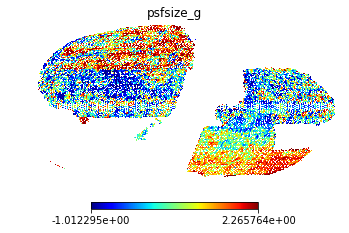

In [7]:
elem = 'psfsize_g'
m = np.zeros(NPIX)

m[df_norms.pixel_id.to_numpy()] = df_norms[elem].to_numpy()
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, format='%e', norm='hist', cmap="jet", notext=False, rot=(120, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True, hold=True)


In [8]:
from desiutil.plots import plot_sky_binned

Using 129 x 400 grid in cos(DEC) x RA with pixel area 0.799 sq.deg.


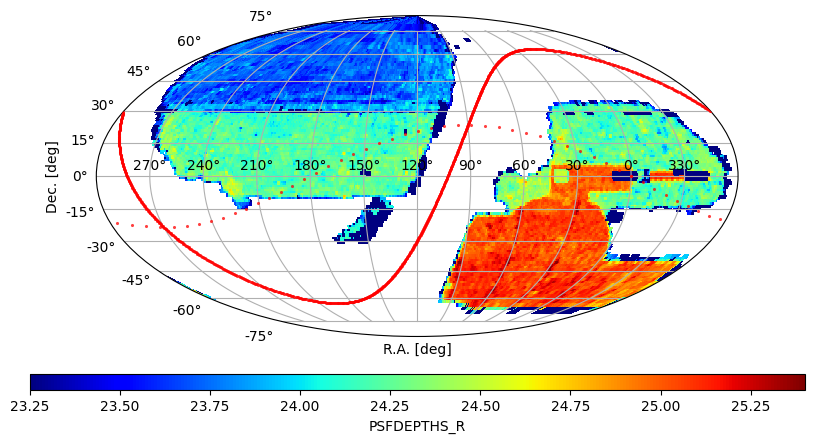

In [11]:
ax = plot_sky_binned(df_norms.ra,df_norms.dec, data=df_norms.psfdepth_r, cmap='jet',label='PSFDEPTHS_R', plot_type='grid', verbose=True,max_bin_area=0.8, clip_lo=23.25, clip_hi=25.5)

Using 82 x 252 grid in cos(DEC) x RA with pixel area 1.996 sq.deg.


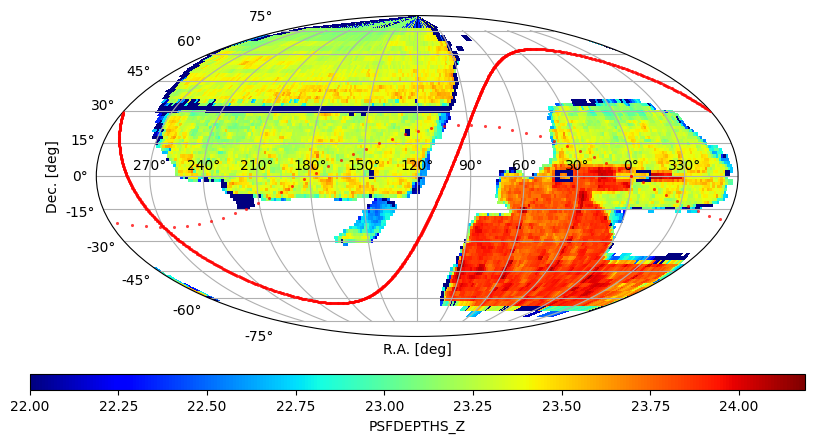

In [33]:
ax = plot_sky_binned(df_norms.ra,df_norms.dec, data=df_norms.psfdepth_z, cmap='jet',label='PSFDEPTHS_Z', plot_type='grid', verbose=True,max_bin_area=2, clip_lo=22)

Using 82 x 252 grid in cos(DEC) x RA with pixel area 1.996 sq.deg.


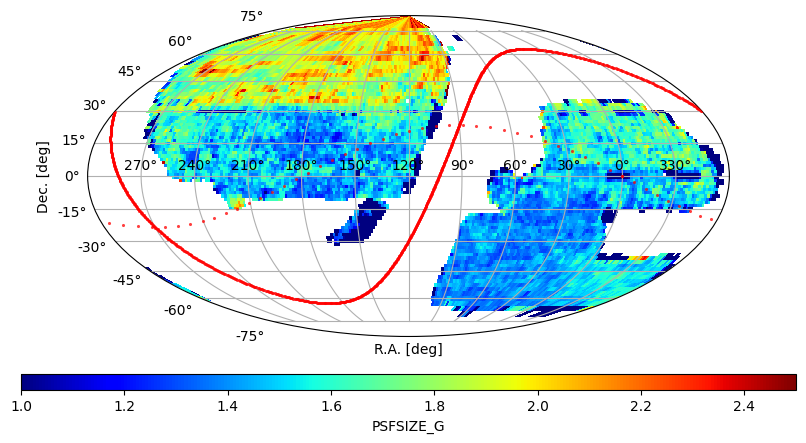

In [35]:
ax = plot_sky_binned(df_norms.ra,df_norms.dec, data=df_norms.psfsize_g, cmap='jet',label='PSFSIZE_G', plot_type='grid', verbose=True,max_bin_area=2, clip_lo=1, clip_hi=2.5)


In [ ]:
### 1. Get a catalogue of all objects in the Galaxy Survey and prepare the north area

### NORTH

In [12]:
df_north = pd.read_csv('../../bricks_data/galaxy_catalogue_north.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})




In [13]:
df_south = pd.read_csv('../../bricks_data/galaxy_catalogue_south.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})


In [14]:
# exploring the overlap:

intersection = pd.Series(list(set(df_north.BrickID) & set(df_south.BrickID)))
print(len(intersection))

10896


In [15]:
print(len(df_north.BrickID.unique()))
print(len(df_south.BrickID.unique()))
print(len(df_north.BrickID.unique()) + len(df_south.BrickID.unique()))

89085
248966
338051


In [16]:
df = pd.concat((df_south, df_north), axis=0)


In [17]:
df_intersect = df[~(df['BrickID'].isin(intersection))]

In [18]:
print(len(df))
print(len(df_intersect))

119022287
113223027


In [19]:
print(df.shape)
duplicates_removed = df_intersect.drop_duplicates()

print(duplicates_removed.shape)

(119022287, 6)
(118987119, 6)


In [20]:
df = duplicates_removed

print(len(df.BrickID.unique()))

327155


In [21]:
print(df.isna().sum())

BrickID         0
RA         151866
DEC        151866
LRG             0
ELG             0
QSO             0
dtype: int64


In [22]:
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_objects = df.dropna(axis=0, inplace=False, how='any')

print(len(df_objects.BrickID.unique()))
print(len(df_objects))

320915
118835253


In [ ]:
df_objects.head()

### 2. Get Galaxy Count per Healpy Pixel


In [27]:
# LRG

df_LRG = df_objects[df_objects["LRG"] == 1]
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)

ra_LRG = df_LRG["RA"].to_numpy(copy=True)

theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 13226092
[  1558   1560   1561 ... 757955 758427 758428]
Mean LRGs per Pixel: 34.68129147972656


,pixel_id,lrg
0,1558,2
1,1560,1
2,1561,3
3,1562,1
4,1564,2


Using 82 x 252 grid in cos(DEC) x RA with pixel area 1.996 sq.deg.
Number of ELGs in Sample: 49417200
[  1558   1559   1560 ... 758428 758429 758430]
Mean ELGs per Pixel: 129.4355535765735
[[  1558      6]
 [  1559      3]
 [  1560      7]
 ...
 [758428     12]
 [758429      4]
 [758430      6]]
   pixel_id  elg
0      1558    6
1      1559    3
2      1560    7
3      1561    4
4      1562    5


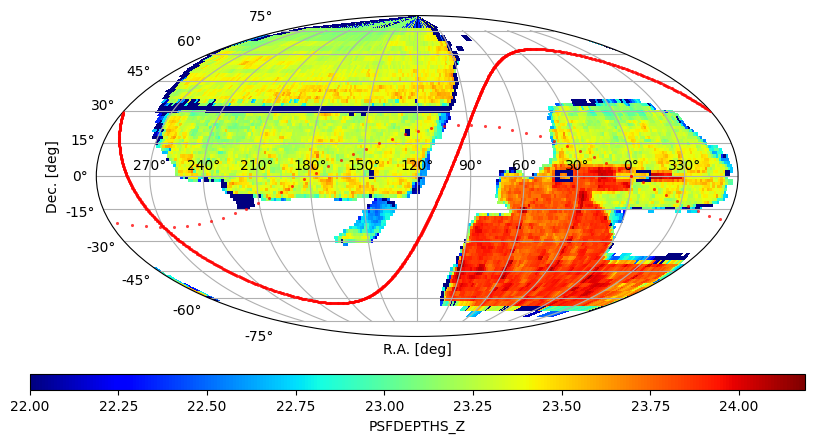

In [28]:
# elg

df_ELG = df_objects[df_objects["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
ax = plot_sky_binned(df_norms.ra,df_norms.dec, data=df_norms.psfdepth_z, cmap='jet',label='PSFDEPTHS_Z', plot_type='grid', verbose=True,max_bin_area=2, clip_lo=22)

dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

In [29]:
df_QSO = df_objects[df_objects["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 61869617
[  1558   1559   1560 ... 758428 758429 758430]
Mean QSOs per Pixel: 162.0416722322184
[[  1558      9]
 [  1559      5]
 [  1560      8]
 ...
 [758428      6]
 [758429      6]
 [758430      4]]
   pixel_id  qso
0      1558    9
1      1559    5
2      1560    8
3      1561    6
4      1562    6


In [30]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id      0
lrg         557
elg         128
qso         105
dtype: int64
(381361, 2) (381790, 2) (381813, 2) (381918, 4)


In [31]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())
print(df.shape)

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64
(381302, 4)


### 3. Plotting Galaxy Densities


<ipython-input-67-345c76e981b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['ra'], df_plot['dec'] = hp.pix2ang(NSIDE,df_plot.pixel_id, lonlat=True)


Using healpix map with NSIDE=64 and pixel area 0.839 sq.deg.


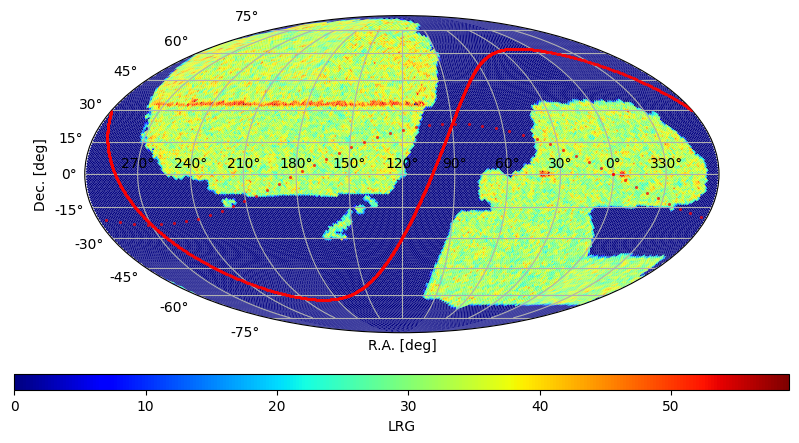

In [67]:
df_plot = df[df.lrg < 60]

df_plot['ra'], df_plot['dec'] = hp.pix2ang(NSIDE,df_plot.pixel_id, lonlat=True)


ax = plot_sky_binned(df_plot.ra,df_plot.dec, data=df_plot.lrg, cmap='jet',label='LRG', plot_type='healpix', verbose=True,max_bin_area=1.5)

<ipython-input-68-319a555d36bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['ra'], df_plot['dec'] = hp.pix2ang(NSIDE,df_plot.pixel_id, lonlat=True)


Using healpix map with NSIDE=64 and pixel area 0.839 sq.deg.


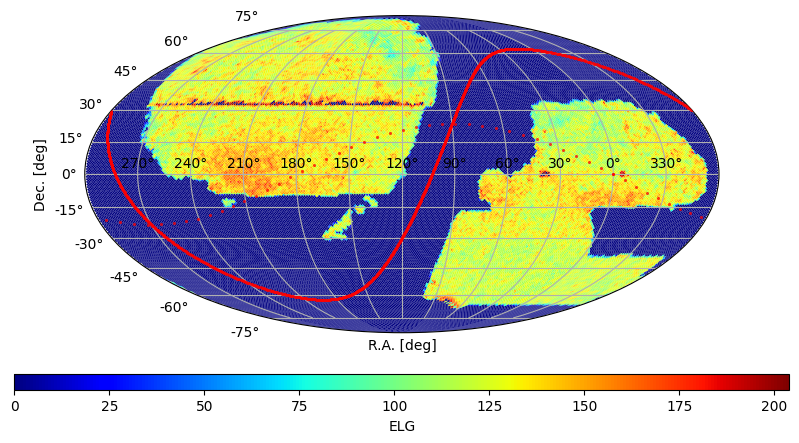

In [68]:
df_plot = df[df.elg < 205]

df_plot['ra'], df_plot['dec'] = hp.pix2ang(NSIDE,df_plot.pixel_id, lonlat=True)


ax = plot_sky_binned(df_plot.ra,df_plot.dec, data=df_plot.elg, cmap='jet',label='ELG', plot_type='healpix', verbose=True,max_bin_area=1.5, clip_hi=205)

In [81]:
df_plot = df[df.qso < 245]
m_QSO = np.zeros(NPIX)
print(m_QSO)

[0. 0. 0. ... 0. 0. 0.]


Using healpix map with NSIDE=64 and pixel area 0.839 sq.deg.


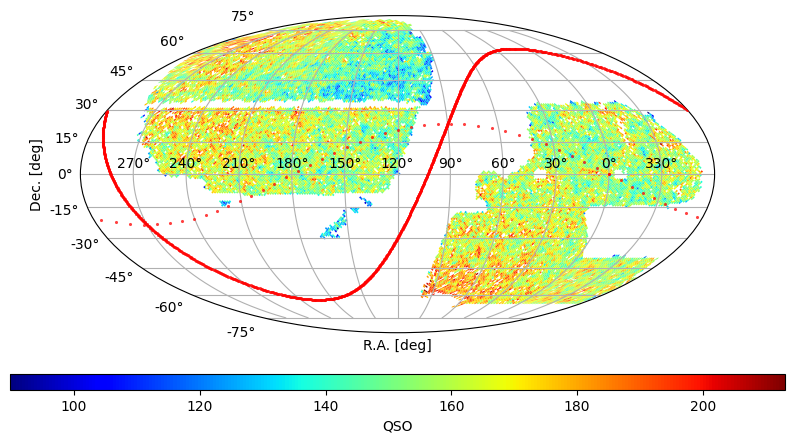

In [82]:
ra, dec = hp.pix2ang(NSIDE,range(NPIX), lonlat=True)
m_QSO[df_plot.pixel_id.to_numpy()] = df_plot.qso.to_numpy()
m_QSO = m_QSO.astype(float)
mask = (m_QSO == 0.0)
m_QSO[mask] = np.nan

ax = plot_sky_binned(ra,dec, data=m_QSO, cmap='jet',label='QSO', plot_type='healpix', verbose=True,max_bin_area=1.5)




In [ ]:
m_LRG = np.zeros(NPIX)

m_LRG[df.pixel_id.to_numpy()] = df.lrg.to_numpy()
mask = (m_LRG == 0)
m_LRG[mask] = np.nan
hp.mollview(m_LRG, title="LRG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
m_ELG = np.zeros(NPIX)

m_ELG[df.pixel_id.to_numpy()] = df.elg.to_numpy()
mask = (m_ELG == 0)
m_ELG[mask] = np.nan
hp.mollview(m_ELG, title="ELG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
m_QSO = np.zeros(NPIX)

m_QSO[df.pixel_id.to_numpy()] = df.qso.to_numpy()
mask = (m_QSO == 0)
m_QSO[mask] = np.nan
hp.mollview(m_QSO, title="QSO", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
# Getting Exposure Densities across pixels

with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [ ]:
df = df.astype(int)
df.head()



In [ ]:
pix_ids = df.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df['exposures'] = exp_len

df.head()

In [ ]:
df = df.astype(int)


In [ ]:
m_EXP = np.zeros(NPIX)

m_EXP[df.pixel_id.to_numpy()] = df.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

### 4. Importing the Systematics Values and Appending them to the df.


#### a. Stellar Density

In [ ]:
df_stellar_north = pd.read_csv('../../bricks_data/stellar_catalogue_north.csv')


In [ ]:
df_stellar_south = pd.read_csv('../../bricks_data/stellar_catalogue_south.csv')

In [ ]:
df_stellar_north.head()

In [ ]:
print(len(df_stellar_north) + len(df_stellar_south))

In [ ]:
df_stellar = pd.concat((df_stellar_south, df_stellar_north), axis=0)


In [ ]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [ ]:
# REMOVING OUTLIERS
print(df_stellar.shape)

In [ ]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [ ]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4)]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4)]
print(df_stellar.shape)


In [ ]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()


In [ ]:
#Dividing RMAG Column into 1000 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=10000, labels=False)
df_stellar['percent_RMAG'].value_counts()


In [ ]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [ ]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=10000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=10000, labels=False)
df_stellar.shape

In [ ]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [ ]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [ ]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

In [ ]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [ ]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

In [ ]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

In [ ]:
df.head()

In [ ]:
m_Stellar = np.zeros(NPIX)

m_Stellar[df.pixel_id.to_numpy()] = df.stellar.to_numpy()
mask = (m_Stellar == 0)
m_Stellar[mask] = np.nan
hp.mollview(m_Stellar, title="Stellar", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0),
            badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

#### EBV Extraction

In [ ]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery

In [ ]:
from dustmaps.config import config

config['data_dir'] = '/Users/edgareggert/astrostatistics/data_preprocessing/.dustmapsrc'

In [ ]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE, pixels_ids, lonlat=True)
ra_ebv = subpixel_coords[0]
dec_ebv = subpixel_coords[1]

In [ ]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [ ]:
df.EBV.describe()
df.head()


In [ ]:
m_EBV = np.zeros(NPIX)

m_EBV[df.pixel_id.to_numpy()] = df.EBV.to_numpy()
mask = (m_EBV == 0)
m_EBV[mask] = np.nan
hp.mollview(m_EBV, title="EBV", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
df.exposures = df.exposures.astype(int)
df.head()

In [ ]:
df.to_csv('../../bricks_data/dataset_galdense.csv', index=False)



In [ ]:
df = pd.read_csv('../../bricks_data/dataset_galdense.csv',
                 dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                        'EBV': 'float'})

#### Geometric Systematics Values, not involving edge pixels


exptime
airmass
fwhm
ccdskysb
meansky
galdepth
psfdepth
psfnorm_mean
gausspsfdepth
pixel_fraction


In [ ]:
with open('../../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geo_dict = pickle.load(f)
    f.close()

print(len(geo_dict.keys()))

In [ ]:
sys_list = []
for key in geo_dict.keys():
    ind_sys_list = geo_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass',
                                                'ccdskysb_g',
                                                'ccdskysb_r',
                                                'ccdskysb_z',
                                                'exptime_g',
                                                'exptime_r',
                                                'exptime_z',
                                                'meansky_g',
                                                'meansky_r',
                                                'meansky_z',
                                                'galdepth_g',
                                                'galdepth_r',
                                                'galdepth_z',
                                                'seeing_g',
                                                'seeing_r',
                                                'seeing_z',
                                                'psfdepth_g',
                                                'psfdepth_r',
                                                'psfdepth_z',
                                                'psfnorm_mean_g',
                                                'psfnorm_mean_r',
                                                'psfnorm_mean_z',
                                                'gausspsfdepth_g',
                                                'gausspsfdepth_r',
                                                'gausspsfdepth_z',
                                                'pixel_covered',
                                                'pixel_id'])



In [ ]:
print(len((df_sys_geo_no)))

In [ ]:
df_geo = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(len(df))
print(len(df_geo))

In [ ]:
print(df_geo.isna().sum())

In [ ]:
df_geo.dropna(axis=0, inplace=True)
print(df_geo.isna().sum())

In [ ]:
print(df_geo.describe())

In [ ]:
df_geo.to_csv('../../bricks_data/dataset_geometric.csv', index=False)


#### Plotting All Densities and systematics together


In [ ]:
df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

In [ ]:
cols = list(df_geo.columns)
cols.remove('pixel_id')


In [ ]:
df_geo.head()

In [ ]:
nrows = 32
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(200,200))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]

    m = np.zeros(NPIX)

    m[df_geo.pixel_id.to_numpy()] = df_geo[elem].to_numpy()
    mask = (m == 0)
    m[mask] = np.nan
    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1),format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True, hold=True)
    #hp.graticule()
    i += 1

plt.show()


### 5. Outlier Removal

In [ ]:
df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

df_geo.describe()


#### a. Experiment with densities


In [ ]:
df_geo['lrg_n'] = (df_geo['lrg']/df_geo.lrg.mean()) - 1
df_geo['elg_n'] = (df_geo['elg']/df_geo.elg.mean()) - 1
df_geo['qso_n'] = (df_geo['qso']/df_geo.qso.mean()) - 1


zscore = lambda x: abs((x - x.median()) / x.std())

In [ ]:
print(len(df_geo[df_geo.lrg_n > 1]), round(df_geo.lrg_n.mean()))
print(len(df_geo[df_geo.elg_n > 1]), round(df_geo.elg_n.mean()))
print(len(df_geo[df_geo.qso_n > 1]), round(df_geo.qso_n.mean()))

In [ ]:
print(df_geo.shape)
df_geo['Z'] = df_geo['galdepth_g'].transform(zscore)
df_geo = df_geo[(df_geo['Z'] < 3)]
df_geo['Z'] = df_geo['galdepth_r'].transform(zscore)
df_geo = df_geo[(df_geo['Z'] < 3)]
df_geo['Z'] = df_geo['galdepth_z'].transform(zscore)
df_geo = df_geo[(df_geo['Z'] < 3)]
print(df_geo.shape)


In [ ]:
print(len(df_geo[df_geo.lrg_n > 1]), (df_geo.lrg_n.mean()))
print(len(df_geo[df_geo.elg_n > 1]), (df_geo.elg_n.mean()))
print(len(df_geo[df_geo.qso_n > 1]), (df_geo.qso_n.mean()))

df_geo = df_geo[(df_geo['exposures'] < 300)]
df_geo = df_geo[(df_geo['exposures'] > 5)]

print(len(df_geo[df_geo.lrg_n > 1]), (df_geo.lrg_n.mean()))
print(len(df_geo[df_geo.elg_n > 1]), (df_geo.elg_n.mean()))
print(len(df_geo[df_geo.qso_n > 1]), (df_geo.qso_n.mean()))

In [ ]:
zscore = lambda x: abs((x - x.median()) / x.std())
col = list(df_geo.columns)
df_no_outlier = df_geo


#### Removing All Outliers


In [ ]:
df_no_outlier = df_geo
factor = 10
print(len(df_geo))
for elem in col:
    if elem == 'stellar':
        factor = 10
    df_no_outlier['Z'] = df_no_outlier[elem].transform(zscore)
    print("Element: ", elem, "| No of Elems with Z higher than factor  : ", len(df_no_outlier[(df_no_outlier['Z'] > factor)]))
    df_no_outlier = df_no_outlier[(df_no_outlier['Z'] < factor)]

print()
print(f"Galaxies Remaining before outlier removal: {len(df_geo)}")
print(f"Galaxies Remaining after outlier removal: {len(df_no_outlier)}")
print(f"Elements cut by outlier removal: {len(df_geo) - len(df_no_outlier)}")

In [ ]:
#df_no_outlier = df_geo

df_no_outlier.describe()
print(df_no_outlier.shape)
print(df_no_outlier.exposures.max())

df_no_outlier = df_no_outlier[df_no_outlier.exposures < 300]
print(df_no_outlier.shape)

df_no_outlier.exposures.max()


### Scaling the Data

In [ ]:
scaler = MinMaxScaler()
#scaler = RobustScaler()

df_scaled = df_no_outlier

cololo = list(df_scaled.columns)
cololo.remove('pixel_id')

df_scaled[cololo] = scaler.fit_transform(df_no_outlier[cololo])

df_scaled.describe()

### Separating train, test and validation sets

In [ ]:
df_train, df_val = train_test_split(df_scaled, test_size=0.4, random_state=666, shuffle=True)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=666, shuffle=True)

total = len(df_train) + len(df_test) + len(df_val)

print(len(df_train)/total)
print(len(df_val)/total)
print(len(df_test)/total)

In [ ]:
df_train.describe()

In [ ]:
df_val.describe()

In [ ]:
df_test.describe()

In [ ]:
df_train.to_csv('../../bricks_data/train.csv', index=False)
df_val.to_csv('../../bricks_data/val.csv', index=False)
df_test.to_csv('../../bricks_data/test.csv', index=False)


### Plotting all different types of outliers that are removed

#### a. exposures


In [ ]:
zscore = lambda x: abs((x - x.median()) / x.std())

df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

In [ ]:

plt.hist(df_geo.exposures, range=[0, 300])
df_no_outlier = df_geo

In [ ]:
elem = 'exposures'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['exposures'] > 100)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### b. pixel_id -> Plotting State of Current Catalogue



In [ ]:
elem = 'pixel_id'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] < 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### c. lrg


In [ ]:
elem = 'lrg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### d. elg


In [ ]:
elem = 'elg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. qso


In [ ]:
elem = 'qso'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. stellar


In [ ]:
elem = 'stellar'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### f. EBV



In [ ]:
elem = 'EBV'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### g. exptime_g

In [ ]:
elem = 'exptime_g'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()


#### Plotting All combined

In [ ]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')
print(len(cols))

In [ ]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(150,150))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]
    df_no_outlier['Z'] = df_geo[elem].transform(zscore)

    df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

    m = np.zeros(NPIX)

    m[df_outlier.pixel_id.to_numpy()] = 1
    mask = (m == 0)
    m[mask] = np.nan

    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1), min=-5, max=2, cbar=False, cmap="Reds", notext=False,
                rot=(100, 0, 0), badcolor='white',
                remove_dip=True, remove_mono=True, hold=True)
    #hp.graticule()
    i += 1

plt.show()
